In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [2]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    #create our xs and ys
    x = np.linspace(a,b,n+1)
    y = np.linspace(c,d,n+1)
    h = x[1]-x[0]
    
    #create the T matrix
    I = np.eye(n-1)
    
    top_t = np.diag(np.ones(n-2),1)
    mid_t = np.diag(np.ones(n-1)*-4)
    bot_t = np.diag(np.ones(n-2),-1)
    
    T = top_t + mid_t + bot_t
    
    #create the A matrix
    A_1 = scipy.linalg.block_diag(*[T]*(n-1))
    A_2 = np.diag(np.ones((n-1)*(n-2)), k=(n-1))
    A_3 = np.diag(np.ones((n-1)*(n-2)), k=-(n-1))
                  
    A = A_1 + A_2 + A_3
    A = (1/(h**2))*A
    A = sp.csr_matrix(A)
    
    #create p
    p = np.zeros((n-1,n-1))
    
    for i in range(1,n):
        p[i-1,0] = (1/(h**2))*g(x[0],y[i])
        p[i-1,n-2] = (1/(h**2))*g(x[n], y[i])
    
    #create q
    middle = np.zeros((n-3,n-1))
    top = (1/(h**2))*np.array([g(x[i],y[0]) for i in range(1,n)])
    bottom = (1/(h**2))*np.array([g(x[i],y[n]) for i in range(1,n)])
    q = np.vstack((top,middle,bottom))
    
    #create f
    f_ = np.zeros((n-1,n-1))
    for i in range(1,n):
        for j in range(1,n):
            f_[i-1,j-1] = f(x[j],y[i])
    rs = np.ravel(f_-p-q)
    
    #solve for U
    U = spla.spsolve(A,rs)
    return U.reshape(n-1,n-1)

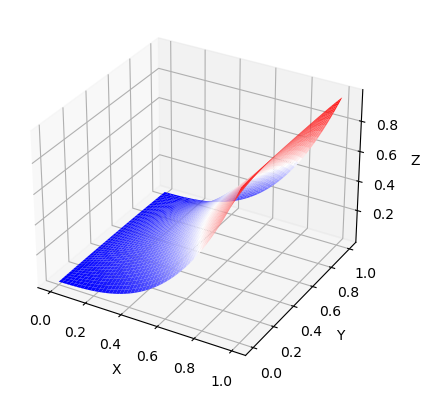

In [3]:
#set up the problem
a = 0
b = 1
c = 0 
d = 1
n = 100
f = lambda x,y: 0*x*y
g = lambda x,y: x**3

#solve for U and plot
U = poisson_square(a,b,c,d,f,g,n)
x,y = np.linspace(a,b,n-1), np.linspace(c,d,n-1)
X,Y = np.meshgrid(x,y)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X,Y,U,cmap='bwr')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

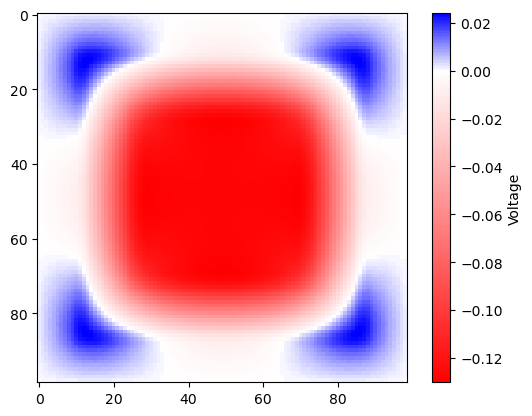

In [4]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

#set up the problem
a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n = 100
X = np.linspace(a1,b1,n-1)
Y = np.linspace(c1,d1,n-1)
X,Y = np.meshgrid(X,Y)
f = lambda x,y: -source(x,y)
g = lambda x,y: x*y*0

#solve for U and plot
U = poisson_square(a1,b1,c1,d1,f,g,n)
plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Voltage")
plt.show()